In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import QuantileTransformer as qt
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import Generator
from Discriminator import Discriminator
from ParticleDataset import ParticleDataset

In [20]:
QT = qt(output_distribution='normal',n_quantiles=20000,subsample=100000)
dataset = ParticleDataset('Full_Sim_10M.csv', 'Full_Sim_55M_stats.csv',QT)
df_N = pd.read_csv('Full_Sim_10M.csv')
df_N[' rx'] = np.sqrt(df_N[' xx']**2+df_N[' yy']**2)
df_N['theta'] = np.arccos(df_N[' pzz']/np.sqrt(df_N[' pxx']**2+df_N[' pyy']**2+df_N[' pzz']**2))
dataloader = DataLoader(dataset.data, batch_size = 2**9, shuffle = True)

In [21]:
N_z=100
mps_device = torch.device('mps')
net_G = Generator.Generator(N_z).to(mps_device)
net_D = Discriminator().to(mps_device)
#print(net_G,net_D)

In [ ]:
optimizer_G = optim.Adam(net_G.parameters(), lr = 0.0001, betas= (0.5,0.999))
optimizer_D = optim.Adam(net_D.parameters(), lr = 0.0001, betas= (0.5,0.999))

In [ ]:
def weights_init(m):
    if isinstance(m,nn.Linear):
        nn.init.normal_(m.weight.data, 0.0 ,0.02)
    elif isinstance(m,nn.BatchNorm1d):
        nn.init.normal_(m.weight.data, 1,0.02)

In [51]:
def plot_correlations(x,y,bins=[400,400],loglog=False,Xlim=None,Ylim=None):
  H,xb,yb = np.histogram2d(x,y,bins=bins,range=[[x.min(), x.max()], [y.min(), y.max()]])
  X , Y = np.meshgrid(xb,yb)
  plt.pcolormesh(X,Y,np.log10(H.T))
  if loglog:
    plt.xscale('log')
    plt.yscale('log')
  if Xlim!=None:
      plt.xlim(Xlim)
  if Ylim!=None:
      plt.ylim(Ylim)
  plt.colorbar()
  plt.show()

In [52]:
def plots(df):
  plot_correlations(df[' xx'],df[' yy'])
  Ebin = 10**np.linspace(-7,0,400)
  Tbin = 10**np.linspace(1, 8,400)
  plot_correlations(df[' time'],df[' eneg'] ,bins = [Tbin,Ebin], loglog=True)
  plot_correlations(df[' rx'],df['theta'])
  plot_correlations(df[' phi_p'],df[' phi_x'])

In [57]:
def transform(df, dataset, fake_p):
    norm_param_list = [' rx',' xx',' yy',' rp',' phi_p',' pzz',' eneg',' time']
    A_p = dataset.quantiles.inverse_transform(fake_p)
    A_p[:,0] = A_p[:,0]**2
    A_p[:,1] = np.exp(A_p[:,1])*A_p[:,0]
    A_p[:,2] = np.exp(A_p[:,2])*A_p[:,0]
    for i in range(len(norm_param_list)):
        max = dataset.norm['max'][norm_param_list[i]]
        min = dataset.norm['min'][norm_param_list[i]]
        if i in [3,6,7]:
            df[norm_param_list[i]] = min + (max-min)*np.exp(-A_p[:,i])
        elif i==5:
            A_p[:,i] = np.sqrt((A_p[:,i]**(-1)-1)*15)
            df[norm_param_list[i]] = max - (max-min)*np.exp(-A_p[:,i])
        elif i in [0,1,2,4]:
            df[norm_param_list[i]] = min + (max-min)*A_p[:,i]
    df[' phi_x'] = np.arctan2(df[' yy'],df[' xx'])+np.pi
    df[' xx'] = df[' rx']*np.cos(df[' phi_x']-np.pi)
    df[' yy'] = df[' rx']*np.sin(df[' phi_x']-np.pi)
    df[' pxx'] = df[' rp']*np.cos(df[' phi_p']-np.pi)
    df[' pyy'] = df[' rp']*np.sin(df[' phi_p']-np.pi)
    df['theta'] = np.arccos(df[' pzz']/np.sqrt(df[' pzz']**2+df[' rp']**2))
    return df

In [47]:
G_losses = []
D_losses = []
iters = 0
num_epochs = 100

#net_G.apply(weights_init)
#net_D.apply(weights_init)
generated_df = pd.DataFrame([])

print("Starting Training Loop...")

for epoch in tqdm.tqdm_notebook(range(num_epochs), desc=' epochs', position=0):
    net_G.to(mps_device)
    net_G.train()

    avg_error_G, avg_error_D = 0, 0
    avg_Dx, avg_DGz1, avg_DGz2 = 0., 0., 0.

    for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):

        # Update the discriminator network

        ## Train with all-real batch
        net_D.zero_grad()
        b_size = len(data)
        real_data = data.to(mps_device)
        
        output = net_D(real_data)

        err_D_real = -torch.mean(output)
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        noise = torch.randn(b_size, N_z, device=mps_device)
        fake_p = net_G(noise)

        output = net_D(fake_p.detach())
        err_D_fake = torch.mean(output)
        fake_p.to(mps_device)
        err_D = err_D_real + err_D_fake
        err_D.backward()

        # update the discriminator network
        optimizer_D.step()
        
        # Update the Generator network
        net_G.zero_grad()
        output = net_D(fake_p)
        err_G = -torch.mean(output)
        err_G.backward()
        
        # update the generator network
        optimizer_G.step()
        
        # computing the average losses and discriminator
        avg_error_G += err_G.item()
        avg_error_D += err_D.item()

        iters += 1
        
    if len(G_losses)>0:
        if avg_error_G<G_losses[-1]:
            torch.save(net_G.state_dict(), 'saved_Gen.pt')
    if np.mod(epoch,10)==0:
        noise = torch.randn(1154756, N_z, device='cpu')
        net_G.eval()
        net_G.to('cpu')
        fake_p = net_G(noise).detach().numpy()
        generated_df = pd.DataFrame([])
        param_list = [' rx',' phi_x',' rp',' phi_p',' pzz',' eneg',' time']
        for i in range(len(param_list)):
            generated_df[param_list[i]]= fake_p[:,i]
        plots(transform(generated_df, dataset, fake_p))
    G_losses.append(avg_error_G)
    D_losses.append(avg_error_D)
    print(f'{epoch}/{num_epochs}\tLoss_D: {avg_error_D:.4f}\tLoss_G: {avg_error_G:.4f}')

Starting Training Loop...


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_61806/871427700.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs), desc=' epochs', position=0):


 epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_61806/871427700.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


NameError: name 'optimizer_D' is not defined

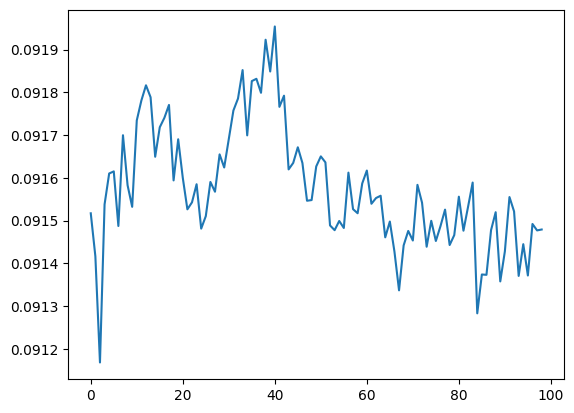

In [48]:
KLD = pd.read_csv('KL_div.csv')
KL_div = KLD['0'].values

plt.plot(KL_div[1:])

In [49]:
net_G = Generator.Generator(N_z).to(mps_device)
net_G.load_state_dict(torch.load('Saved_Gen.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


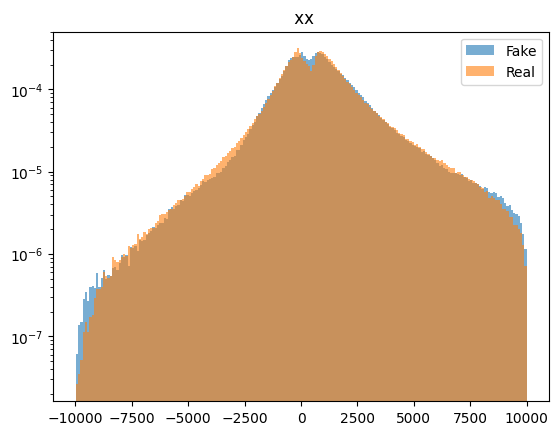

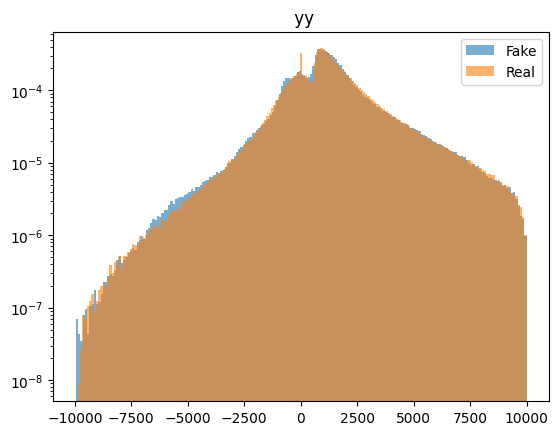

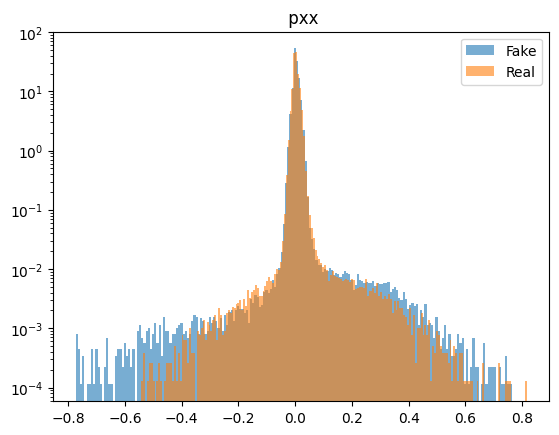

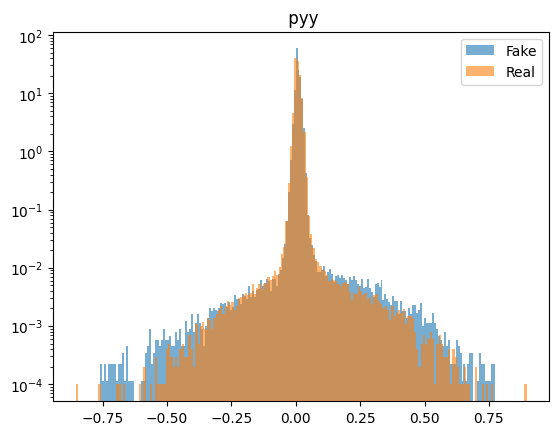

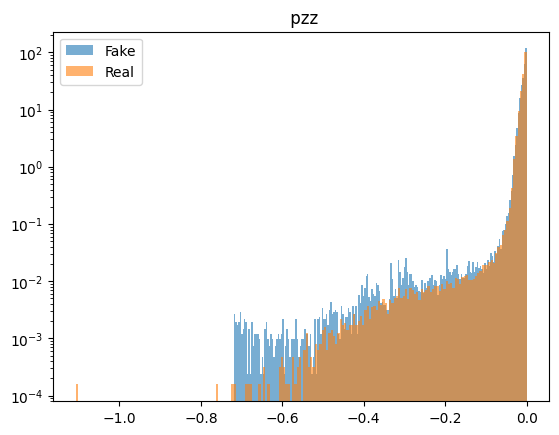

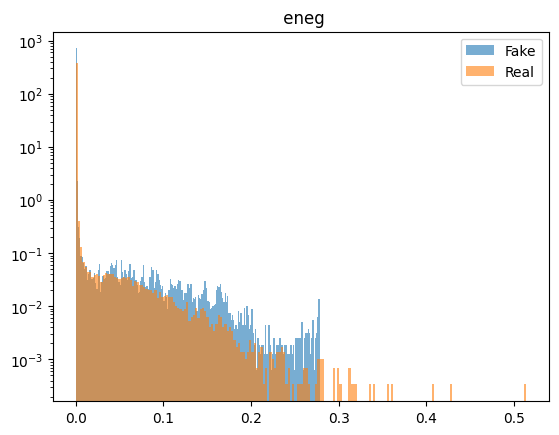

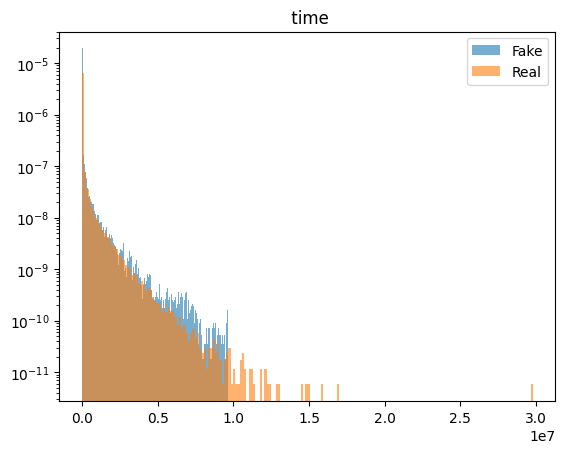

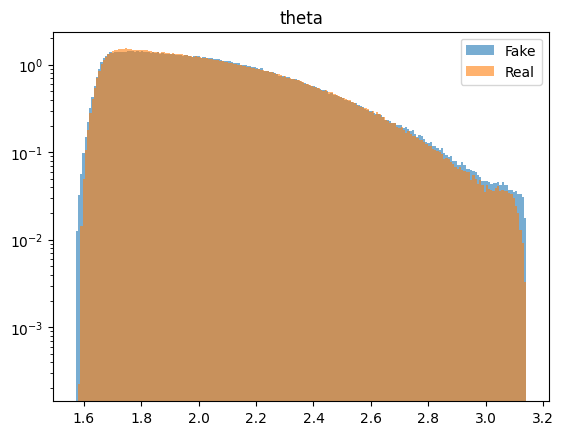

<Figure size 640x480 with 0 Axes>

In [58]:
fin_param_list = [' xx',' yy',' pxx',' pyy',' pzz',' eneg',' time','theta']
param_list = [' rx',' xx',' yy',' rp',' phi_p',' pzz',' eneg',' time']
noise = torch.randn(1154756, N_z, device='cpu')
net_G.eval()
net_G.to('cpu')
fake_p = net_G(noise).detach().numpy()
generated_df = pd.DataFrame([])
for i in range(len(param_list)):
    generated_df[param_list[i]] = fake_p[:,i]
DF = transform(generated_df, dataset, fake_p)
for j in range(len(param_list)):
    plt.hist(generated_df[fin_param_list[j]],bins=200,density=True,alpha=0.6)
    plt.hist(df_N[fin_param_list[j]],bins=200,density=True,alpha=0.6)
    plt.yscale('log')
    plt.title(fin_param_list[j])
    plt.legend(["Fake","Real"])
    plt.figure()

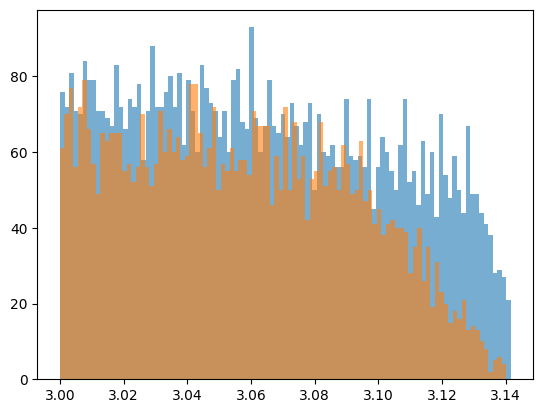

In [59]:
mask=3
crit_theta_fake = DF[DF['theta']>=mask]
crit_theta_real = df_N[df_N['theta']>=mask]
plt.hist(crit_theta_fake['theta'],bins=100,alpha=0.6)
plt.hist(crit_theta_real['theta'],bins=100,alpha=0.6)
plt.show()

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_61806/2550337054.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


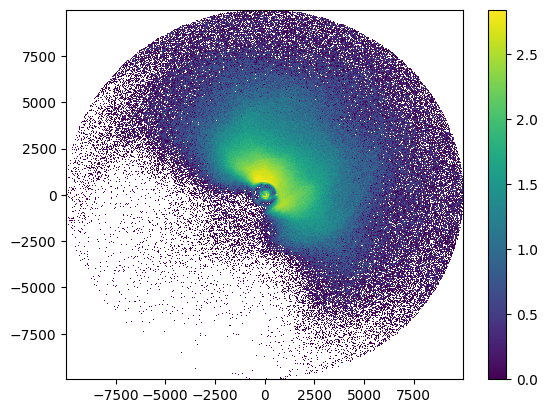

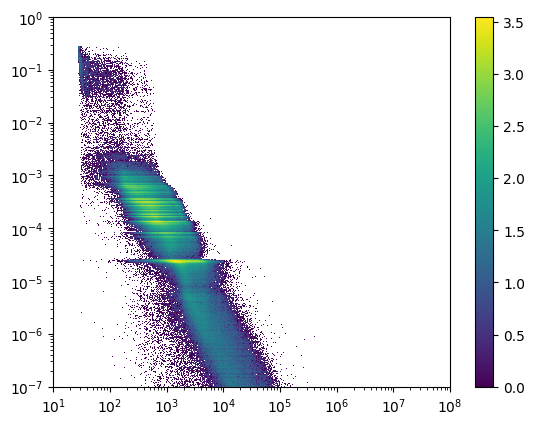

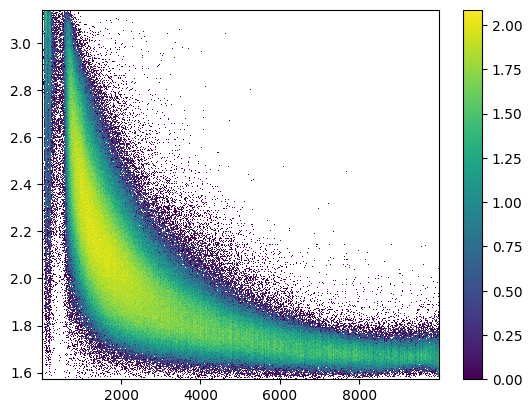

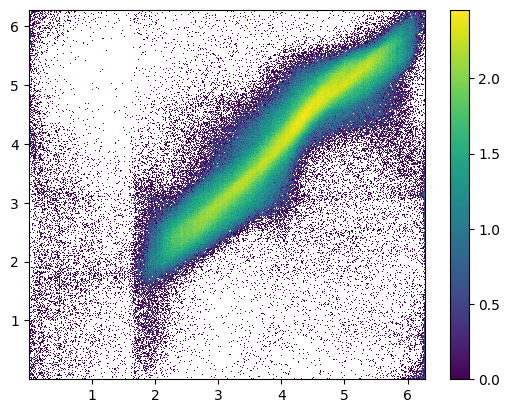

In [60]:
plots(DF)